<a href="https://colab.research.google.com/github/anruki/UFV_Visualizacion/blob/main/EjerciciosClase/Ventas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREDICCIONES DE VENTAS
---
#### Clase 18/10/2024
#### Asignatura visualización de datos






---



CSV a estudiar:

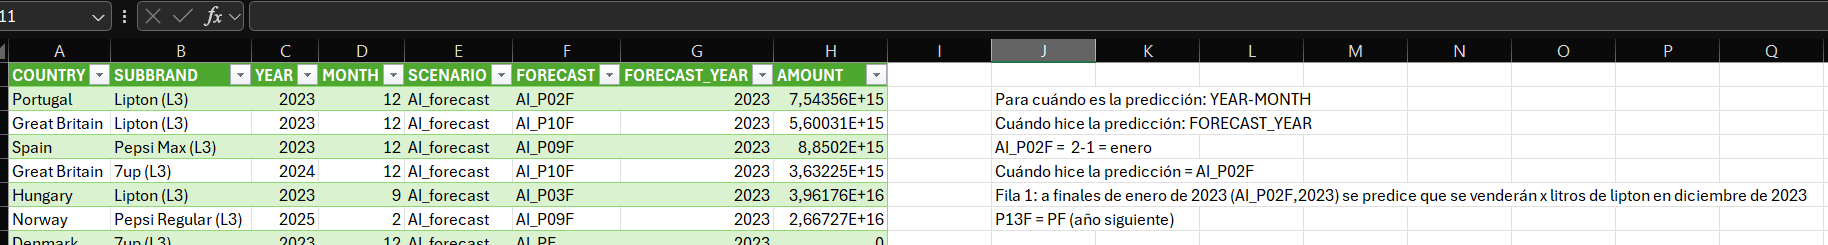

### Importación de librerías y descarga del dataset:

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

Cargamos el DataFrame en `df` con registros de predicciones de ventas:

In [50]:
# Leer el archivo CSV
df = pd.read_csv('/content/datos_ejercicio_ventas.csv')
df.head(3)

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847


### Primer estudio del dataset

Tiene columnas:

In [51]:
df.columns

Index(['COUNTRY', 'SUBBRAND', 'YEAR', 'MONTH', 'SCENARIO', 'FORECAST',
       'FORECAST_YEAR', 'AMOUNT'],
      dtype='object')

* `COUNTRY` El país al que se refieren los datos.
* `SUBBRAND` Una subcategoría específica dentro de una marca o línea de productos.
* `YEAR` El año al que se refieren los datos.
* `MONTH` El mes al que se refieren los datos.
* `SCENARIO` El escenario bajo el cual se han generado los datos. Por ejemplo, "AI_forecast" podría indicar que estos son pronósticos generados por inteligencia artificial.
* `FORECAST` Un identificador del pronóstico.
* `FORECAST_YEAR` El año para el cual se está haciendo el pronóstico.
* `AMOUNT` La cantidad de ventas, ingresos u otra métrica que se está midiendo.

`* ChatGPT descripciones`

Y registros:

In [52]:
df.size

149328



---



**Añadir columna DATE = MONTH + YEAR**

Incluye `MONTH` y `YEAR`

In [53]:
import pandas as pd

# Crear la columna DATE como Periodo de Mes
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1)).dt.to_period('M')
# Convertimos la columna 'DATE' a tipo datetime para poder graficarla
df['DATE'] = pd.to_datetime(df['DATE'].astype(str), format='%Y-%m')

**Añadir Columna SUBBRAND_GROUPED**

Agrupamos los productos que son de la misma marca como `7up (L3)` y `7up Free (L3)`

In [54]:
df['SUBBRAND'].unique()

array(['Lipton (L3)', 'Pepsi Max (L3)', '7up (L3)', 'Pepsi Regular (L3)',
       'Mountain Dew (L3)', '7up Free (L3)'], dtype=object)

In [55]:
# Creamos un diccionario para agrupar las submarcas
subbrand_mapping = {
    'Pepsi Max (L3)': 'Pepsi',
    'Pepsi Regular (L3)': 'Pepsi',
    '7up (L3)': '7up',
    '7up Free (L3)': '7up',
    'Lipton (L3)': 'Lipton',
    'Mountain Dew (L3)': 'Mountain Dew'
}

# Usamos .loc[] para asegurarnos de que estamos modificando el DataFrame correctamente
df.loc[:, 'SUBBRAND_GROUPED'] = df['SUBBRAND'].map(subbrand_mapping)

## Preguntas a responder para entender los datos:


1.   NºActuals y Forecasts
2.   Horizonte de predicción
Cuando haces una predicción, ej: estás en enero:

  *  predices x ventas para febrero, entonces horizonte de predicción = 1
  *  predices x ventas en febrero, en marzo y, en abril z, entonces horizonte de predicción = 3.

3.  Nº Países y de productos
4.  Histórico de actuals/forecasts
  - Primer dato de ventas real hasta el último
  - Primer dato de veentas forecast hasta el último
5.  Forecasts distintos




---



## 1. Nº Actuals y Forecasts

`AI_forecast` son las predicciones de ventas y `actuals` las ventas reales que se han hecho.

In [56]:
scenarios = df['SCENARIO'].unique()
print(scenarios)

['AI_forecast' 'actual']


Cuántos valores reales hay, y cuántos predichos

In [57]:
df['SCENARIO'].value_counts()

,count
SCENARIO,
AI_forecast,17766
actual,900


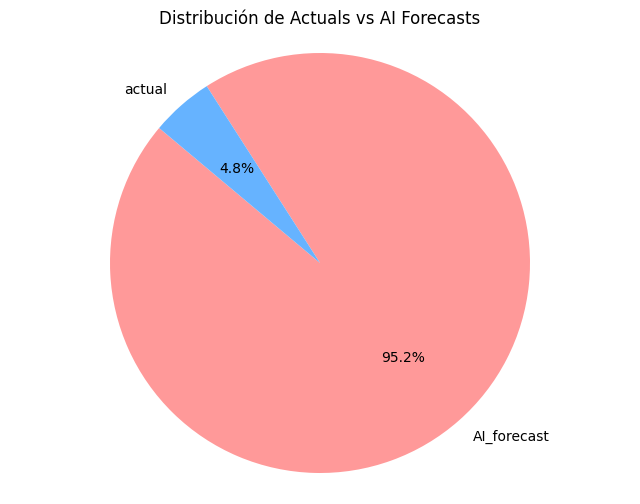

In [58]:
# Contar el número de entradas para cada escenario
scenario_counts = df['SCENARIO'].value_counts()

# Crear el gráfico de pastel
plt.figure(figsize=(8, 6))
plt.pie(scenario_counts, labels=scenario_counts.index, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff'])
plt.title('Distribución de Actuals vs AI Forecasts')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Mostrar el gráfico
plt.show()

## 2. Horizonte de predicción

FORECAST CON FORECAST YEAR - MONTH CON YEAR

Solo queremos las predicciones.

In [59]:
forecasts = df[df['SCENARIO'] == scenarios[0]]

Se realizan durante los siguientes meses:

`PXF -> X - 1 mes`

In [60]:
forecasts['FORECAST'].unique()

array(['AI_P02F', 'AI_P10F', 'AI_P09F', 'AI_P03F', 'AI_PF', 'AI_P11F',
       'AI_P06F', 'AI_P05F', 'AI_P07F', 'AI_P12F', 'AI_P08F', 'AI_P04F'],
      dtype=object)

Y solamente durante el año 2023

In [61]:
forecasts['FORECAST_YEAR'].unique()

array([2023.])

Por otra parte `MONTH` y `YEAR` indica para cuándo es la predicción.

In [62]:
forecasts['MONTH'].unique()

array([12,  9,  2,  4,  7, 11,  1,  6, 10,  3,  5,  8])

In [63]:
forecasts['YEAR'].unique()

array([2023, 2024, 2025])

Tomando como ejemplo un solo `FORECAST = AI_P02F` que son las predicciones hechas en enero.

In [64]:
forecasts_jan = forecasts[forecasts['FORECAST'] == 'AI_P02F']
forecasts_jan.size

12780

Hay predicciones para el 2023 y 2024

In [65]:
forecasts_jan.loc[:, 'HORIZON'] = np.where(
    forecasts_jan['YEAR'] == 2024,
    forecasts_jan['MONTH'] - 1 + 12,  # Si el año es 2024, restar 1 al mes y sumar 12
    forecasts_jan['MONTH'] - 1        # Si el año no es 2024, solo restar 1 al mes
)

<ipython-input-65-0a4b681d65f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasts_jan.loc[:, 'HORIZON'] = np.where(


In [66]:
forecasts_jan.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,DATE,SUBBRAND_GROUPED,HORIZON
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,7.543562e+05,2023-12-01,Lipton,11
7,Netherlands,Mountain Dew (L3),2024,4,AI_forecast,AI_P02F,2023.0,0.000000e+00,2024-04-01,Mountain Dew,15
8,Great Britain,Pepsi Max (L3),2023,9,AI_forecast,AI_P02F,2023.0,1.138557e+07,2023-09-01,Pepsi,8
28,Italy,7up (L3),2023,6,AI_forecast,AI_P02F,2023.0,1.867226e+04,2023-06-01,7up,5
30,Denmark,7up Free (L3),2024,5,AI_forecast,AI_P02F,2023.0,1.500290e+04,2024-05-01,7up,16


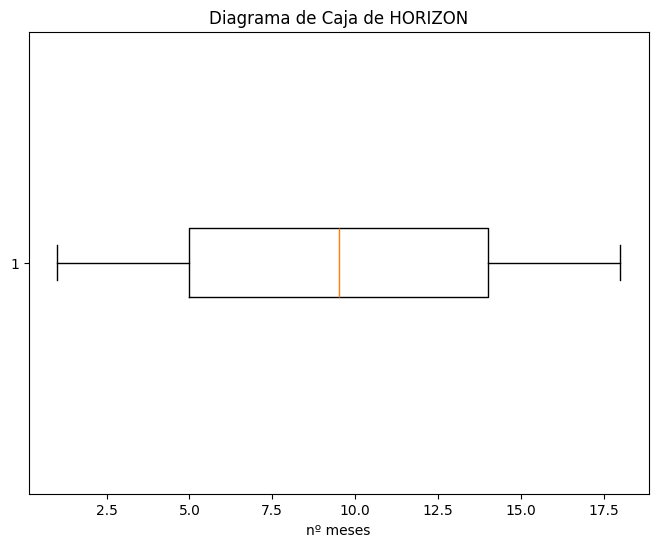

In [67]:
plt.figure(figsize=(8, 6))
plt.boxplot(forecasts_jan['HORIZON'], vert=False)
plt.title('Diagrama de Caja de HORIZON')
plt.xlabel('nº meses')
plt.show()

De media, se hacen predicciones con un horizonte de 9.5 meses.

In [68]:
forecasts_jan['HORIZON'].mean()

9.5



---



## 3. Nº de países y de productos

* Países:

In [69]:
paises = df['COUNTRY'].unique()
print(paises)

['Portugal' 'Great Britain' 'Spain' 'Hungary' 'Norway' 'Denmark'
 'Netherlands' 'Italy' 'Czech']


En total hay `9` países

In [70]:
paises.size

9

Cada país tiene los siguientes registros en total:

In [71]:
df['COUNTRY'].value_counts()

,count
COUNTRY,
Great Britain,4008
Netherlands,2476
Hungary,2384
Denmark,2294
Spain,2152
Norway,2062
Czech,1403
Portugal,1179
Italy,708


Destacamos que la mayoría de registros de ventas se producen en Gran Bretaña.

* Productos

In [72]:
marcas = df['SUBBRAND_GROUPED'].unique()
productos = df['SUBBRAND'].unique()
print("Productos: ",productos)
print("Marcas: ",marcas)

Productos:  ['Lipton (L3)' 'Pepsi Max (L3)' '7up (L3)' 'Pepsi Regular (L3)'
 'Mountain Dew (L3)' '7up Free (L3)']
Marcas:  ['Lipton' 'Pepsi' '7up' 'Mountain Dew']


En total hay `6` productos de `3` marcas

Cada marca tiene los siguientes registros en total:

In [73]:
df['SUBBRAND_GROUPED'].value_counts()

,count
SUBBRAND_GROUPED,
Pepsi,9234
7up,5037
Lipton,2693
Mountain Dew,1702


## 4.  Histórico de actuals/forecasts
  - Primer dato de ventas real hasta el último
  - Primer dato de veentas forecast hasta el último



---
IMPORTANTE: he usado 'date' en vez de forecast, 'date' muestra para cuando son las predicciones.


---



* Datos reales de ventas

In [74]:
actuals = df[df['SCENARIO'] == scenarios[1]]
actuals.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,DATE,SUBBRAND_GROUPED
277,Portugal,Pepsi Max (L3),2023,10,actual,NaN,NaN,1.885949e+05,2023-10-01,Pepsi
278,Portugal,7up (L3),2023,3,actual,NaN,NaN,2.934971e+05,2023-03-01,7up
279,Portugal,7up (L3),2023,10,actual,NaN,NaN,3.484466e+05,2023-10-01,7up
280,Great Britain,7up Free (L3),2023,10,actual,NaN,NaN,1.172553e+06,2023-10-01,7up
281,Norway,Pepsi Regular (L3),2023,10,actual,NaN,NaN,3.784859e+04,2023-10-01,Pepsi


* Primer dato real de ventas

In [75]:
# Ordenamos el DataFrame por la columna de fechas y seleccionamos el primer registro
actual_first = actuals.sort_values('DATE').iloc[0]
actual_first

,11275
COUNTRY,Norway
SUBBRAND,Pepsi Regular (L3)
YEAR,2023
MONTH,1
SCENARIO,actual
FORECAST,NaN
FORECAST_YEAR,NaN
AMOUNT,34297.395969
DATE,2023-01-01 00:00:00
SUBBRAND_GROUPED,Pepsi


* Último dato real de ventas

In [76]:
# Ordenamos el DataFrame por la columna de fechas y seleccionamos el primer registro
actual_last = actuals.sort_values('DATE').iloc[-1]
actual_last

,14323
COUNTRY,Great Britain
SUBBRAND,Pepsi Max (L3)
YEAR,2024
MONTH,8
SCENARIO,actual
FORECAST,NaN
FORECAST_YEAR,NaN
AMOUNT,14138482.706649
DATE,2024-08-01 00:00:00
SUBBRAND_GROUPED,Pepsi


De manera visual, podemos graficar las ventas de cada producto a lo largo del tiempo.

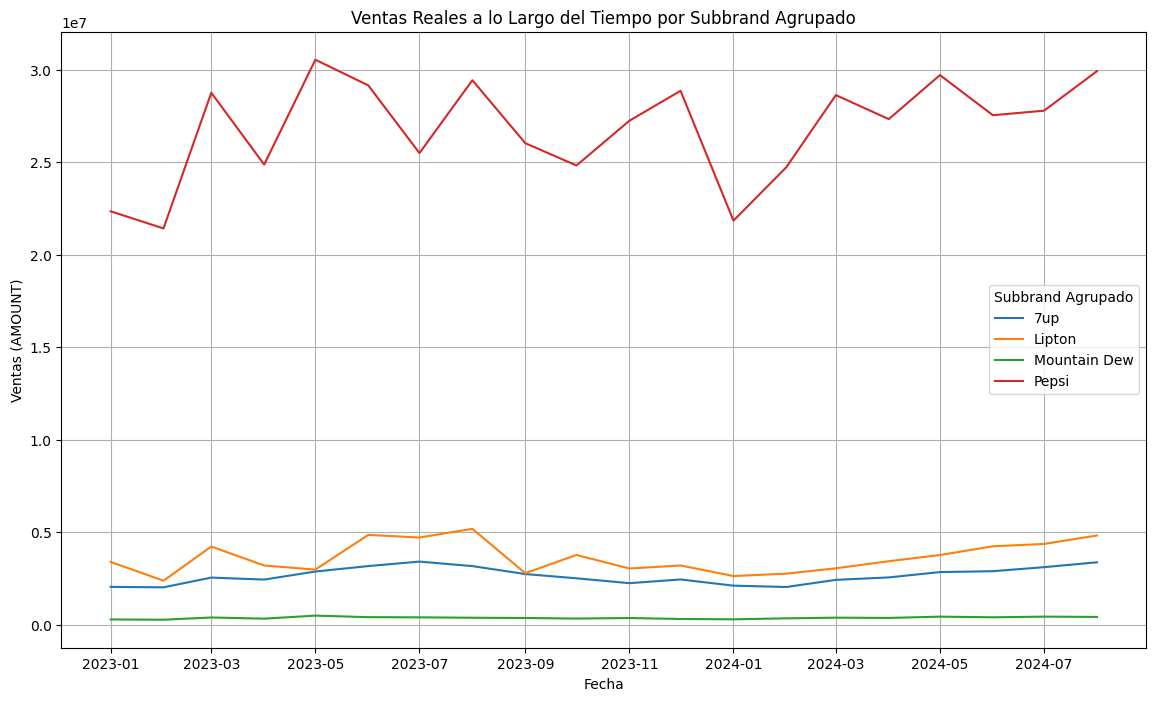

In [77]:
# Agrupamos los datos por fecha y la nueva columna SUBBRAND_GROUPED y sumamos los valores de ventas (AMOUNT)
actuals_grouped = actuals.groupby(['DATE', 'SUBBRAND_GROUPED'])['AMOUNT'].sum().reset_index()


# Configuramos la gráfica
plt.figure(figsize=(14, 8))


# Graficamos una línea para cada subbrand agrupado
for subbrand in actuals_grouped['SUBBRAND_GROUPED'].unique():
    subbrand_data = actuals_grouped[actuals_grouped['SUBBRAND_GROUPED'] == subbrand]
    plt.plot(subbrand_data['DATE'], subbrand_data['AMOUNT'], label=subbrand)

# Añadimos etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Ventas (AMOUNT)')
plt.title('Ventas Reales a lo Largo del Tiempo por Subbrand Agrupado')
plt.legend(title='Subbrand Agrupado')
plt.grid(True)

# Mostramos la gráfica
plt.show()

* Datos predichos de ventas

In [78]:
forecasts = df[df['SCENARIO'] == scenarios[0]]
forecasts.head()

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,DATE,SUBBRAND_GROUPED
0,Portugal,Lipton (L3),2023,12,AI_forecast,AI_P02F,2023.0,754356.237194,2023-12-01,Lipton
1,Great Britain,Lipton (L3),2023,12,AI_forecast,AI_P10F,2023.0,560030.558029,2023-12-01,Lipton
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847,2023-12-01,Pepsi
3,Great Britain,7up (L3),2024,12,AI_forecast,AI_P10F,2023.0,363224.511516,2024-12-01,7up
4,Hungary,Lipton (L3),2023,9,AI_forecast,AI_P03F,2023.0,396176.120491,2023-09-01,Lipton


Nota: `DATE` indica para cuándo es la predicción.

* Primer dato predicho de ventas

In [79]:
# Ordenamos el DataFrame por la columna de fechas y seleccionamos el primer registro
forecast_first = forecasts.sort_values('DATE').iloc[0]
forecast_first

,3628
COUNTRY,Portugal
SUBBRAND,7up (L3)
YEAR,2023
MONTH,1
SCENARIO,AI_forecast
FORECAST,AI_PF
FORECAST_YEAR,2023.0
AMOUNT,289120.980222
DATE,2023-01-01 00:00:00
SUBBRAND_GROUPED,7up


¿Cuántas predicciones se hicieron para esa fecha?

In [80]:
forecasts[forecasts['DATE'] == forecast_first['DATE']].size

710

* Último dato predicho de ventas

In [81]:
# Ordenamos el DataFrame por la columna de fechas y seleccionamos el primer registro
forecast_last = forecasts.sort_values('DATE').iloc[-1]
forecast_last

,15769
COUNTRY,Netherlands
SUBBRAND,Pepsi Max (L3)
YEAR,2025
MONTH,5
SCENARIO,AI_forecast
FORECAST,AI_P12F
FORECAST_YEAR,2023.0
AMOUNT,1024964.029014
DATE,2025-05-01 00:00:00
SUBBRAND_GROUPED,Pepsi


Para saber en qué momento se hizo la primera predicción hay que usar `FORECAST`

Parece que todas las predicciones se hicieron durante el 2023.

In [82]:
forecasts['FORECAST_YEAR'].unique()

array([2023.])

Y para ver en qué mes:

In [83]:
forecasts['FORECAST'].unique()

array(['AI_P02F', 'AI_P10F', 'AI_P09F', 'AI_P03F', 'AI_PF', 'AI_P11F',
       'AI_P06F', 'AI_P05F', 'AI_P07F', 'AI_P12F', 'AI_P08F', 'AI_P04F'],
      dtype=object)

## Preguntas a responder
(Con gráficas)

1. Como se distribuyen las ventas realizadas en:
  * Cada país
  * Cada mes y año
  * Cada marca
2. Cual es la tendencia y estacionalidad de:
  * Todas las ventas del país con menos ventas
  * La marca con más ventas
3. Cuales son las predicciones hechas en España y como de
buenas son

In [84]:
actuals = df[df['SCENARIO'] == scenarios[1]]
forecasts = df[df['SCENARIO'] == scenarios[0]]

# 1. Cómo se distribuyen las ventas realizadas en ...



## CADA PAÍS
Recordamos que los países del dataFrame son:

In [85]:
countries = df['COUNTRY'].unique()
print(countries)

['Portugal' 'Great Britain' 'Spain' 'Hungary' 'Norway' 'Denmark'
 'Netherlands' 'Italy' 'Czech']


De momento analizaremos las ventas reales sucedidas (`actuals`)

### - Ventas totales por país

In [86]:
# Agrupamos los datos por pais y sumamos los valores de ventas (AMOUNT) para cada combinación
actuals_grouped = actuals.groupby(['COUNTRY'])['AMOUNT'].sum().reset_index()
# Ordenar en orden descendente y reasignar al DataFrame original
actuals_grouped = actuals_grouped.sort_values(by='AMOUNT', ascending=False)

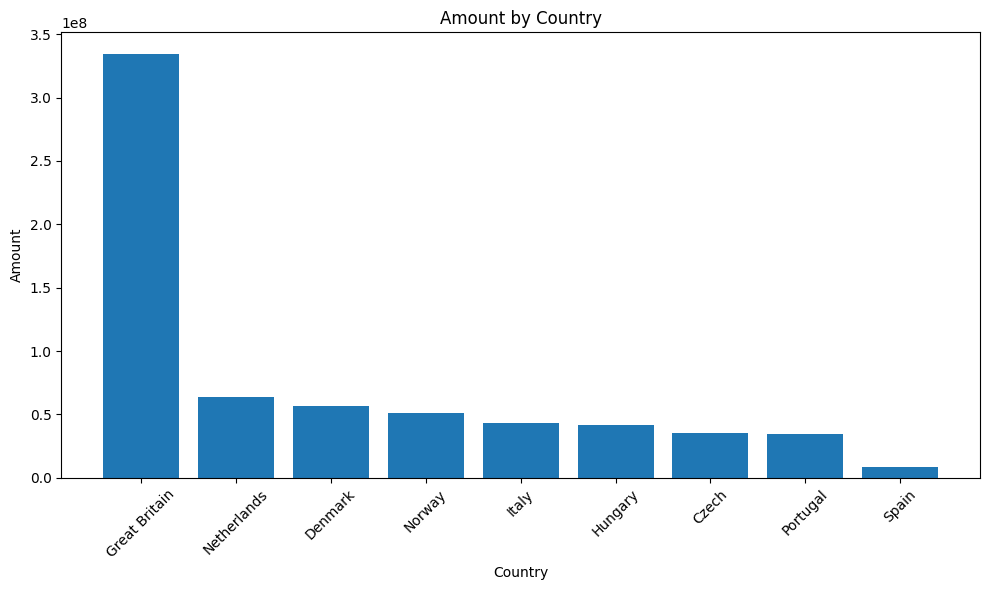

In [87]:

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(actuals_grouped['COUNTRY'], actuals_grouped['AMOUNT'])


# Add labels and title
plt.xlabel('Country')
plt.ylabel('Amount')
plt.title('Amount by Country')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

## Ventas de cada marca por país

In [88]:
# 1. Agrupamos los datos por COUNTRY y SUBBRAND_GROUPED y sumamos los valores de AMOUNT para cada combinación
actuals_grouped = actuals.groupby(['COUNTRY', 'SUBBRAND_GROUPED'])['AMOUNT'].sum().unstack()

# 2. Reordenamos las columnas para que "Pepsi" sea la primera
column_order = ["Pepsi", "7up", "Lipton", "Mountain Dew"]
actuals_grouped = actuals_grouped.reindex(columns=column_order)

# 3. Reordenamos las filas para que los países estén en el orden deseado
country_order = ["Italy", "Denmark", "Norway", "Great Britain", "Hungary", "Czech", "Spain", "Netherlands", "Portugal"]
actuals_grouped = actuals_grouped.reindex(country_order)

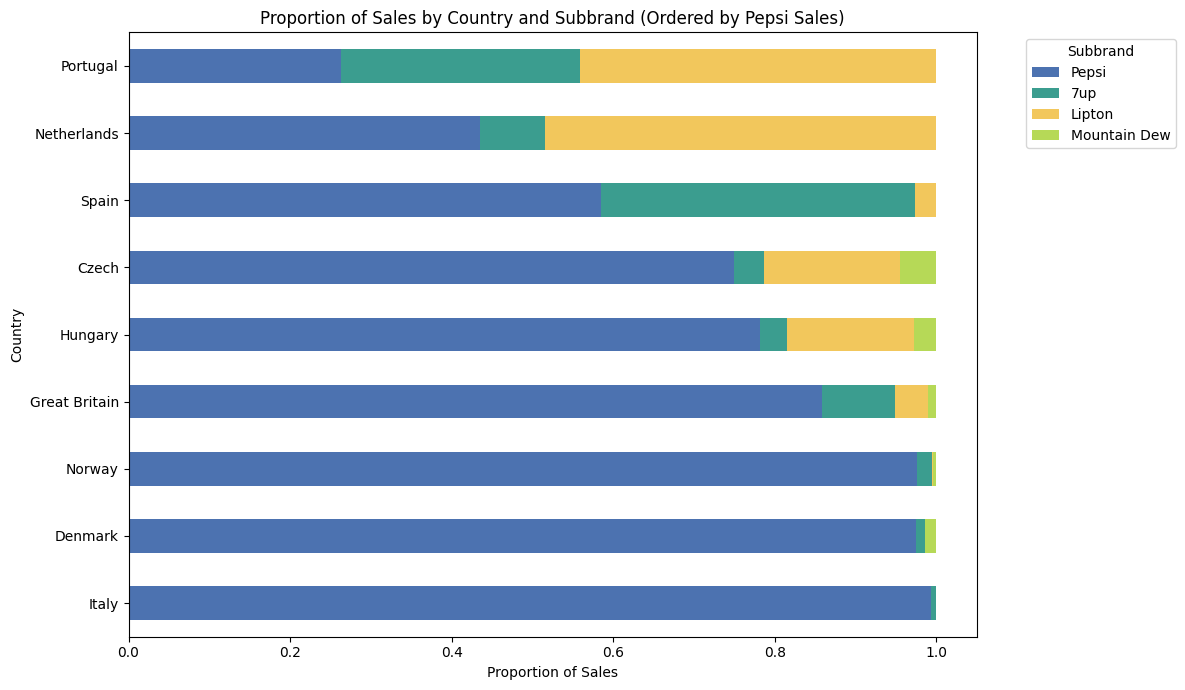

In [89]:
# 4. Normalizamos para obtener proporciones
grouped_data = actuals_grouped.div(actuals_grouped.sum(axis=1), axis=0)

# 5. Configuramos el gráfico de barras apiladas horizontal con los colores especificados
colors = ['#4c72b0', '#3b9d8f', '#f2c75c', '#b6d957']  # Colores personalizados
plt.figure(figsize=(12, 7))
grouped_data.plot(kind='barh', stacked=True, color=colors, ax=plt.gca())  # 'barh' para gráfico horizontal

# 6. Añadir etiquetas y título
plt.xlabel('Proportion of Sales')
plt.ylabel('Country')
plt.title('Proportion of Sales by Country and Subbrand (Ordered by Pepsi Sales)')

# 7. Ajustes finales
plt.xticks(rotation=0)
plt.legend(title='Subbrand', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# 8. Mostrar el gráfico
plt.show()

## Ventas por pais a lo largo del tiempo

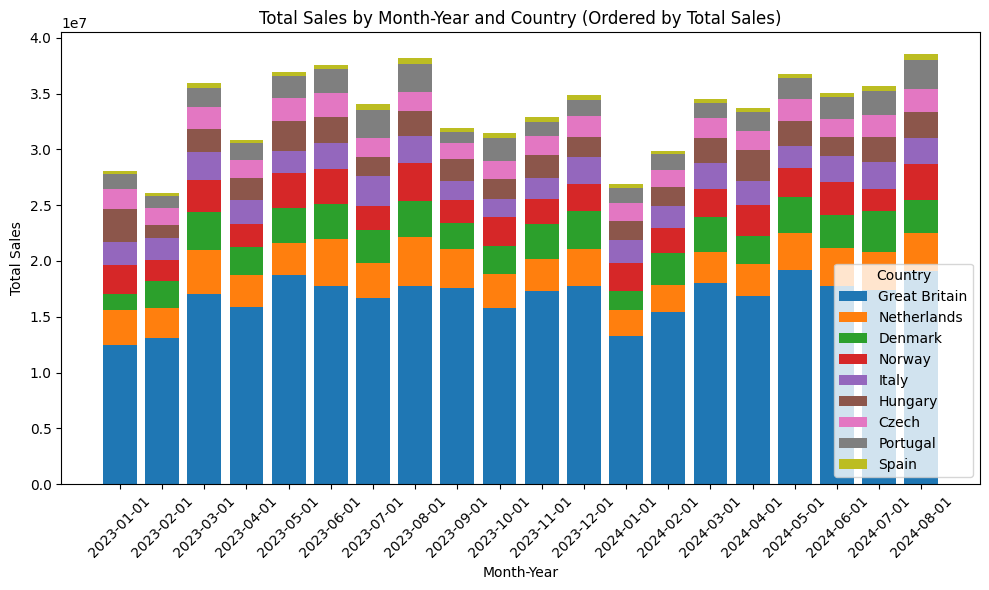

In [90]:
# 3. Agrupamos por DATE y COUNTRY y sumamos AMOUNT
monthly_sales_country = actuals.groupby(['DATE', 'COUNTRY'])['AMOUNT'].sum().reset_index()

# 4. Pivotamos el DataFrame para que cada COUNTRY sea una columna
monthly_sales_pivot = monthly_sales_country.pivot(index='DATE', columns='COUNTRY', values='AMOUNT')

# 5. Calcular el total de ventas por país (suma de las ventas de cada columna)
country_totals = monthly_sales_pivot.sum(axis=0)

# 6. Ordenar los países de acuerdo con el total de ventas, de mayor a menor
monthly_sales_pivot = monthly_sales_pivot[country_totals.sort_values(ascending=False).index]

# 7. Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))

# Inicializamos la posición inferior de cada barra en 0
bottom = [0] * len(monthly_sales_pivot)

# Iteramos sobre cada país para apilar los valores
for country in monthly_sales_pivot.columns:
    plt.bar(monthly_sales_pivot.index.astype(str), monthly_sales_pivot[country], bottom=bottom, label=country)
    # Actualizamos la posición inferior sumando el valor actual
    bottom += monthly_sales_pivot[country].fillna(0)  # fillna(0) por si hay valores nulos

# 8. Etiquetas y título
plt.xlabel('Month-Year')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month-Year and Country (Ordered by Total Sales)')
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje X para mejor visibilidad
plt.legend(title="Country")  # Leyenda para identificar cada COUNTRY

# 9. Mostrar gráfico
plt.tight_layout()
plt.show()

## CADA MES Y AÑO

### Nº total de ventas por mes y por año

In [91]:
actuals['YEAR'].unique()

array([2023, 2024])

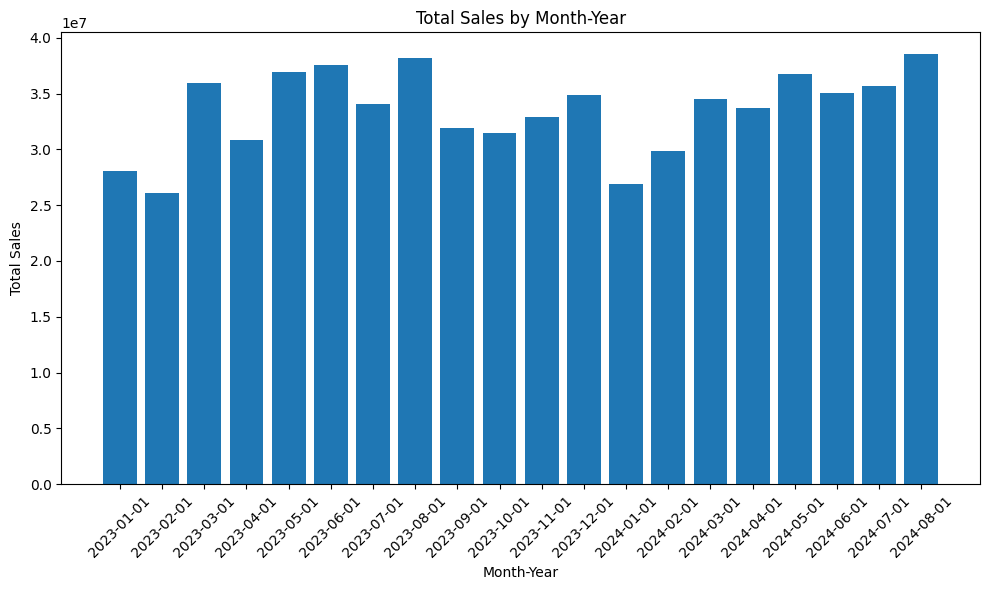

In [92]:
# 3. Agrupamos por YearMonth (mes y año) y sumamos AMOUNT
monthly_sales = actuals.groupby('DATE')['AMOUNT'].sum()

# 4. Creamos el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(monthly_sales.index.astype(str), monthly_sales.values)

# 5. Etiquetas y título
plt.xlabel('Month-Year')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month-Year')
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje X para mejor visibilidad

# Mostramos el gráfico
plt.tight_layout()
plt.show()

### 2023 vs 2024

In [93]:
actuals['YEAR'].unique()

array([2023, 2024])

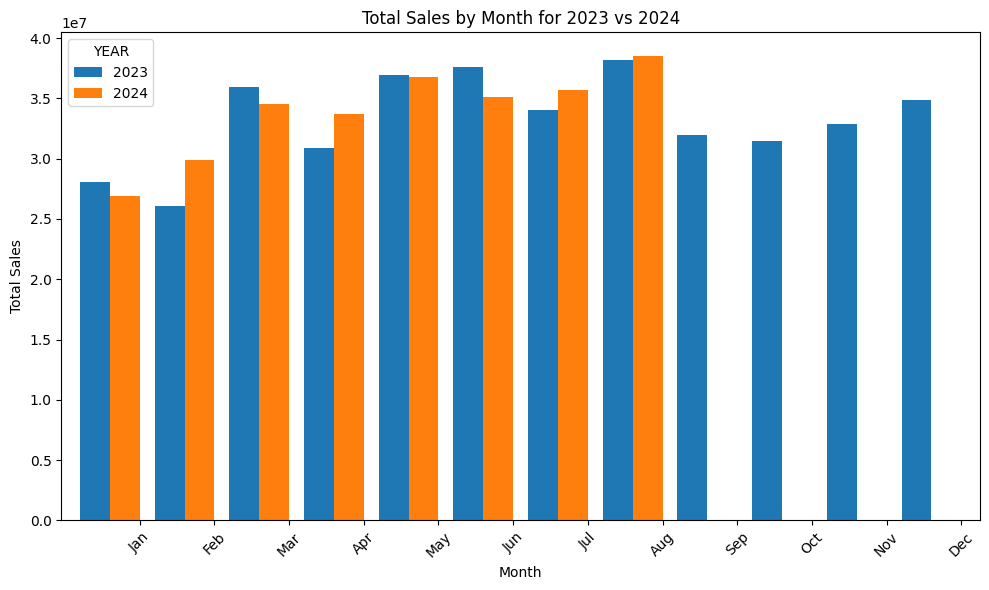

In [94]:
# 2. Agrupamos por MONTH y YEAR, y sumamos las ventas (AMOUNT)
monthly_sales = actuals.groupby(['MONTH', 'YEAR'])['AMOUNT'].sum().unstack()

# 3. Creamos el gráfico de barras agrupadas (side-by-side)
plt.figure(figsize=(10, 6))

# Graficamos las barras
monthly_sales.plot(kind='bar', width=0.8, position=1, ax=plt.gca())

# 4. Etiquetas y título
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month for 2023 vs 2024')

# Añadimos etiquetas en el eje X con los nombres de los meses
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# Mostramos el gráfico
plt.tight_layout()
plt.show()

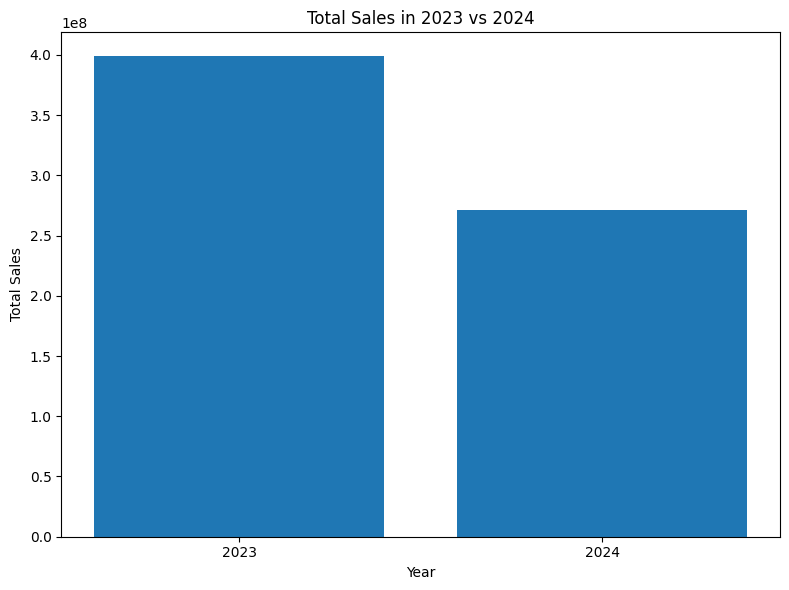

In [95]:
# 2. Agrupamos por YEAR y sumamos AMOUNT para obtener el total de ventas por año
annual_sales = actuals.groupby('YEAR')['AMOUNT'].sum()

# 3. Creamos el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(annual_sales.index.astype(str), annual_sales.values)

# 4. Etiquetas y título
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Sales in 2023 vs 2024')
plt.xticks(rotation=0)  # Aseguramos que las etiquetas de los años estén bien visibles

# Mostrar gráfico
plt.tight_layout()
plt.show()

Como `2023` va de enero a diciembre y `2024` de enero a agosto, se hace una media de ventas/mes

In [96]:
# 2. Agrupamos por YEAR y MONTH y sumamos AMOUNT
monthly_sales = actuals.groupby(['YEAR', 'MONTH'])['AMOUNT'].sum().reset_index()

# 3. Calculamos la media de ventas mensuales por año
average_monthly_sales = monthly_sales.groupby('YEAR')['AMOUNT'].mean()
average_monthly_sales

,AMOUNT
YEAR,
2023,3.323398e+07
2024,3.388824e+07


## Cada marca

### Ventas totales de cada marca

In [97]:
# Agrupamos los datos por pais y sumamos los valores de ventas (AMOUNT) para cada combinación
actuals_grouped = actuals.groupby(['SUBBRAND_GROUPED'])['AMOUNT'].sum().reset_index()
# Ordenar en orden descendente y reasignar al DataFrame original
actuals_grouped = actuals_grouped.sort_values(by='AMOUNT', ascending=False)

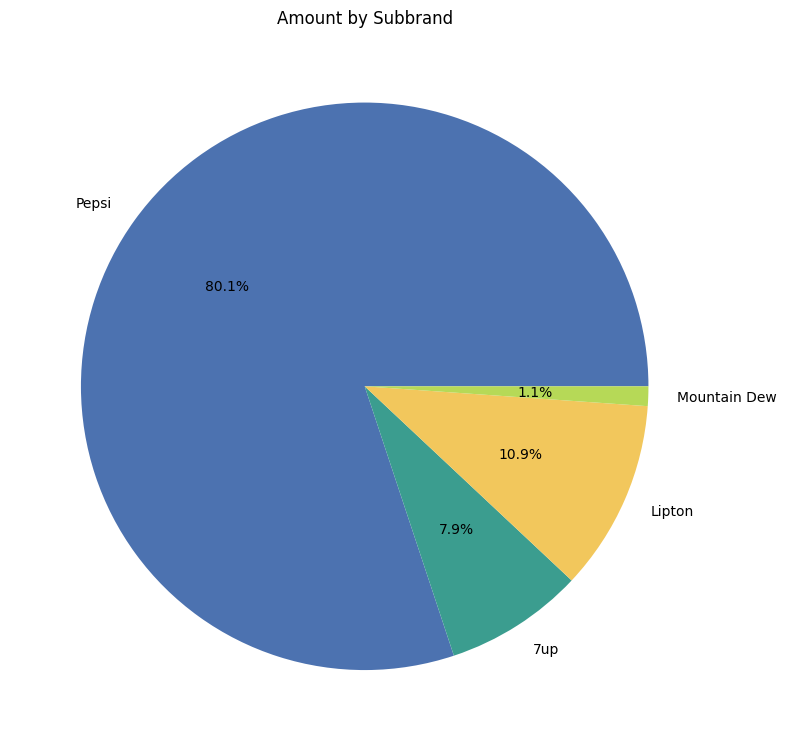

In [98]:
# Ordenar 'actuals_grouped' en el orden correcto de las submarcas
actuals_grouped = actuals_grouped.set_index('SUBBRAND_GROUPED').reindex(["Pepsi", "7up", "Lipton", "Mountain Dew"])

# Definir los colores específicos para cada submarca en el orden correcto
colors = ['#4c72b0', '#3b9d8f', '#f2c75c', '#b6d957']  # Azul para Pepsi, verde azulado para 7up, amarillo dorado para Lipton, verde lima para Mountain Dew

# Crear el gráfico de pastel con los colores especificados
plt.figure(figsize=(8, 8))
plt.pie(actuals_grouped['AMOUNT'],
        labels=actuals_grouped.index,
        autopct='%1.1f%%',
        colors=colors)

# Añadir título
plt.title('Amount by Subbrand')

# Mostrar gráfico
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

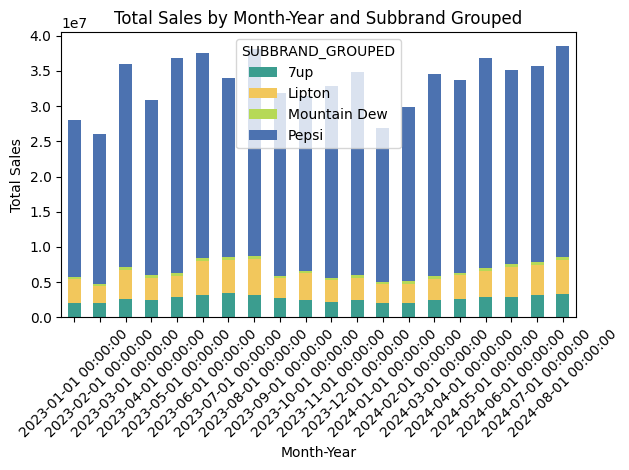

In [99]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Agrupar por DATE y SUBBRAND_GROUPED, luego sumar las ventas (AMOUNT)
monthly_sales = actuals.groupby(['DATE', 'SUBBRAND_GROUPED'])['AMOUNT'].sum().unstack(fill_value=0)

# 2. Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))
colors = ['#3b9d8f',  '#f2c75c','#b6d957','#4c72b0']  # Azul para Pepsi, verde azulado para 7up, amarillo dorado para Lipton, verde lima para Mountain Dew
monthly_sales.plot(kind='bar', stacked=True, color=colors)

# 3. Etiquetas y título
plt.xlabel('Month-Year')
plt.ylabel('Total Sales')
plt.title('Total Sales by Month-Year and Subbrand Grouped')

# 4. Rotar las etiquetas del eje X para mejor visibilidad
plt.xticks(rotation=45)

# 5. Mostrar el gráfico
plt.tight_layout()
plt.show()

# 2. Cual es la tendencia y estacionalidad de:
  * Todas las ventas del país con menos ventas
  * La marca con más ventas

Primero veamos cuál es el país con menos ventas

Agrupo las cantidades de ventas por país y ordeno de mayor a menor

In [100]:
# Asegúrate de que actuals_grouped sea un DataFrame
actuals_grouped = actuals.groupby(['COUNTRY'])['AMOUNT'].sum().reset_index()

# Ahora puedes ordenarlo por 'AMOUNT' como antes
actuals_grouped = actuals_grouped.sort_values(by='AMOUNT', ascending=False)
actuals_grouped.head(9)

,COUNTRY,AMOUNT
2,Great Britain,3.347786e+08
5,Netherlands,6.395943e+07
1,Denmark,5.659668e+07
6,Norway,5.121406e+07
4,Italy,4.345404e+07
3,Hungary,4.153991e+07
0,Czech,3.535164e+07
7,Portugal,3.488807e+07
8,Spain,8.131266e+06


El pais con menos ventas es España :(

In [101]:
actuals_spain = actuals[actuals['COUNTRY'] == 'Spain']

Graficamos:

* El nº de ventas por mes
* El nº de ventas por marca

# 2. Cual es la tendencia y estacionalidad de:
  * Todas las ventas del país con menos ventas

Primero veamos cuál es el país con menos ventas

Agrupo las cantidades de ventas por país y ordeno de mayor a menor

In [102]:
actuals_grouped = actuals.groupby(['COUNTRY'])['AMOUNT'].sum().reset_index()

# Ahora puedes ordenar por 'AMOUNT'
actuals_grouped = actuals_grouped.sort_values(by='AMOUNT', ascending=False)
actuals_grouped.head(9)

,COUNTRY,AMOUNT
2,Great Britain,3.347786e+08
5,Netherlands,6.395943e+07
1,Denmark,5.659668e+07
6,Norway,5.121406e+07
4,Italy,4.345404e+07
3,Hungary,4.153991e+07
0,Czech,3.535164e+07
7,Portugal,3.488807e+07
8,Spain,8.131266e+06


El pais con menos ventas es España :(

In [103]:
actuals_spain = actuals[actuals['COUNTRY'] == 'Spain']

Y el que más ventas tiene es Gran Bretaña

In [104]:
actuals_GB = actuals[actuals['COUNTRY'] == 'Great Britain']

Graficamos:

* El nº de ventas por mes
* El nº de ventas por marca

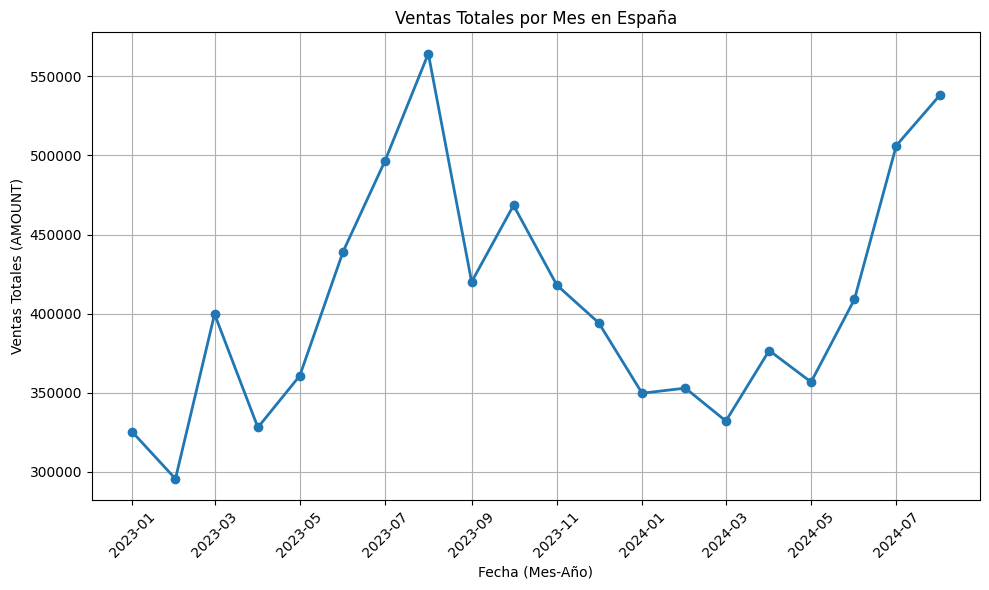

In [105]:
import matplotlib.pyplot as plt
import pandas as pd

# Agrupamos por YearMonth y sumamos las ventas (AMOUNT)
monthly_sales = actuals_spain.groupby('DATE')['AMOUNT'].sum()

# Configuramos la gráfica
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-', linewidth=2)

# Añadimos etiquetas y título
plt.xlabel('Fecha (Mes-Año)')
plt.ylabel('Ventas Totales (AMOUNT)')
plt.title('Ventas Totales por Mes en España')
plt.xticks(rotation=45)
plt.grid(True)

# Mostramos la gráfica
plt.tight_layout()
plt.show()

Si lo comparamos con Gran Bretaña

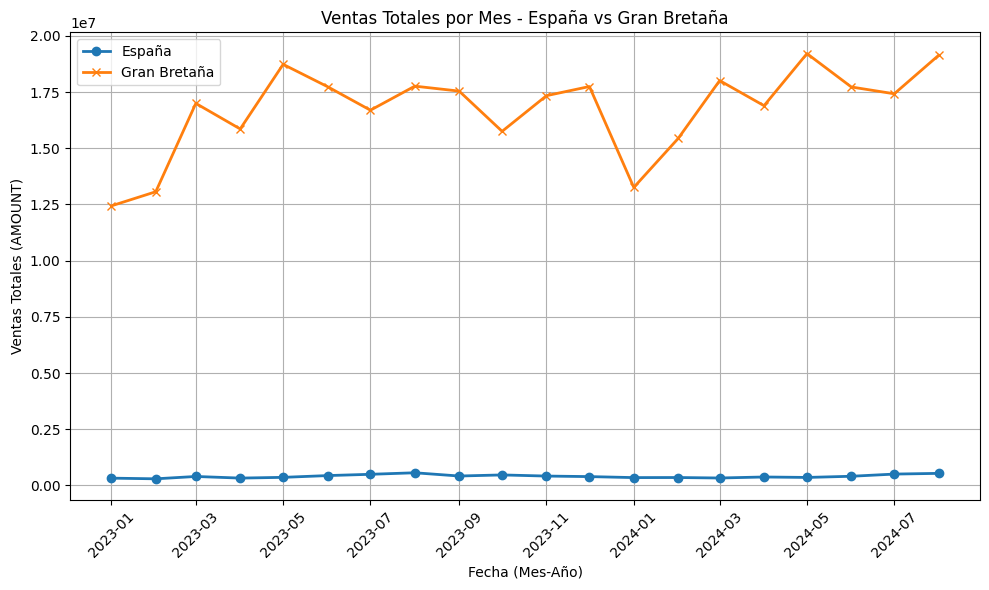

In [106]:
import matplotlib.pyplot as plt
import pandas as pd

# Agrupamos por 'DATE' y sumamos las ventas (AMOUNT) para ambos dataframes
monthly_sales_spain = actuals_spain.groupby('DATE')['AMOUNT'].sum()
monthly_sales_gb = actuals_GB.groupby('DATE')['AMOUNT'].sum()

# Aseguramos que ambas series estén en el mismo formato de fecha
monthly_sales_spain.index = pd.to_datetime(monthly_sales_spain.index)
monthly_sales_gb.index = pd.to_datetime(monthly_sales_gb.index)

# Fusionamos las dos series en un solo dataframe
combined_sales = pd.DataFrame({
    'Spain': monthly_sales_spain,
    'GB': monthly_sales_gb
})

# Configuramos la gráfica
plt.figure(figsize=(10, 6))

# Graficamos ambas series
plt.plot(combined_sales.index, combined_sales['Spain'], marker='o',  linestyle='-', linewidth=2, label='España')
plt.plot(combined_sales.index, combined_sales['GB'], marker='x', linestyle='-', linewidth=2, label='Gran Bretaña')

# Añadimos etiquetas y título
plt.xlabel('Fecha (Mes-Año)')
plt.ylabel('Ventas Totales (AMOUNT)')
plt.title('Ventas Totales por Mes - España vs Gran Bretaña')
plt.xticks(rotation=45)
plt.grid(True)

# Añadimos leyenda
plt.legend()

# Mostramos la gráfica
plt.tight_layout()
plt.show()

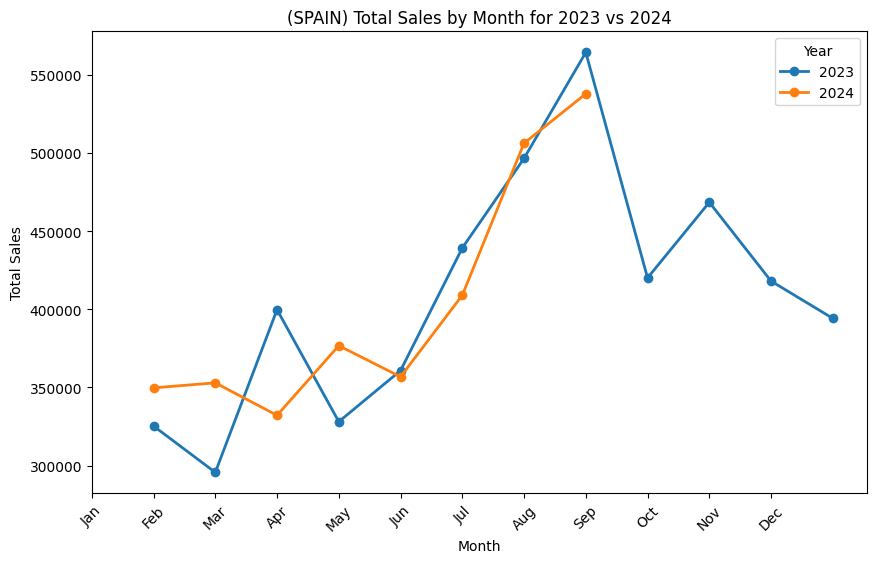

In [107]:
# 2. Agrupamos por MONTH y YEAR, y sumamos las ventas (AMOUNT)
monthly_sales = actuals_spain.groupby(['MONTH', 'YEAR'])['AMOUNT'].sum().unstack()

# 3. Graficamos las líneas
plt.figure(figsize=(10, 6))

# Graficamos las ventas de 2023 y 2024
plt.plot(monthly_sales.index, monthly_sales[2023], label='2023', marker='o', linestyle='-', linewidth=2)
plt.plot(monthly_sales.index, monthly_sales[2024], label='2024', marker='o', linestyle='-', linewidth=2)

# 4. Etiquetas y título
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('(SPAIN) Total Sales by Month for 2023 vs 2024')

# Añadimos etiquetas en el eje X con los nombres de los meses
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# 5. Añadimos leyenda
plt.legend(title="Year")

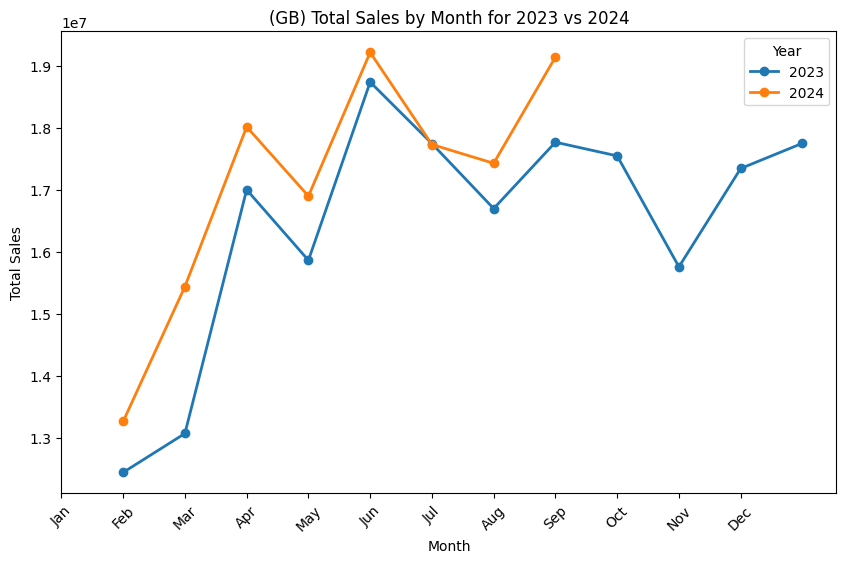

In [108]:
# 2. Agrupamos por MONTH y YEAR, y sumamos las ventas (AMOUNT)
monthly_sales = actuals_GB.groupby(['MONTH', 'YEAR'])['AMOUNT'].sum().unstack()

# 3. Graficamos las líneas
plt.figure(figsize=(10, 6))

# Graficamos las ventas de 2023 y 2024
plt.plot(monthly_sales.index, monthly_sales[2023], label='2023', marker='o', linestyle='-', linewidth=2)
plt.plot(monthly_sales.index, monthly_sales[2024], label='2024', marker='o', linestyle='-', linewidth=2)

# 4. Etiquetas y título
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('(GB) Total Sales by Month for 2023 vs 2024')

# Añadimos etiquetas en el eje X con los nombres de los meses
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

# 5. Añadimos leyenda
plt.legend(title="Year")

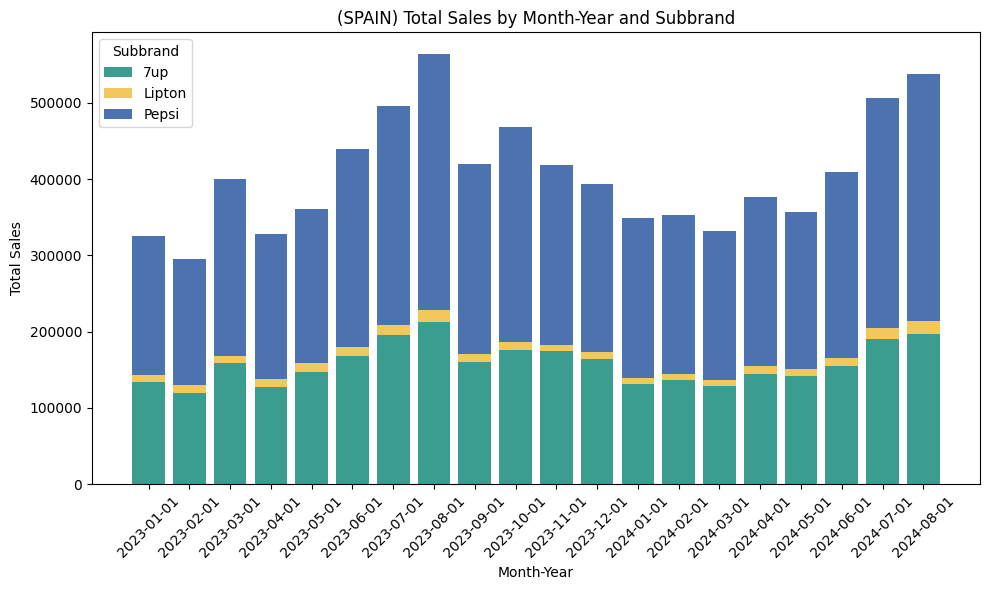

In [114]:
# 3. Agrupamos por YearMonth y SUBBRAND y sumamos AMOUNT
monthly_sales_subbrand = actuals_spain.groupby(['DATE', 'SUBBRAND_GROUPED'])['AMOUNT'].sum().reset_index()

# 4. Pivotamos el DataFrame para que cada SUBBRAND sea una columna
monthly_sales_pivot = monthly_sales_subbrand.pivot(index='DATE', columns='SUBBRAND_GROUPED', values='AMOUNT')

# 5. Colores personalizados
colors = ['#3b9d8f', '#f2c75c','#4c72b0' ]  # Lista de colores

# 6. Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))

# Inicializamos la posición inferior de cada barra en 0
bottom = [0] * len(monthly_sales_pivot)

# Iteramos sobre cada subbrand para apilar los valores y aplicar los colores personalizados
for idx, subbrand in enumerate(monthly_sales_pivot.columns):
    plt.bar(monthly_sales_pivot.index.astype(str), monthly_sales_pivot[subbrand],
            bottom=bottom, label=subbrand, color=colors[idx % len(colors)])  # Usamos idx para asignar el color
    # Actualizamos la posición inferior sumando el valor actual
    bottom += monthly_sales_pivot[subbrand].fillna(0)  # fillna(0) por si hay valores nulos

# 7. Etiquetas y título
plt.xlabel('Month-Year')
plt.ylabel('Total Sales')
plt.title('(SPAIN) Total Sales by Month-Year and Subbrand')
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje X para mejor visibilidad
plt.legend(title="Subbrand")  # Leyenda para identificar cada SUBBRAND

# 8. Mostrar gráfico
plt.tight_layout()
plt.show()

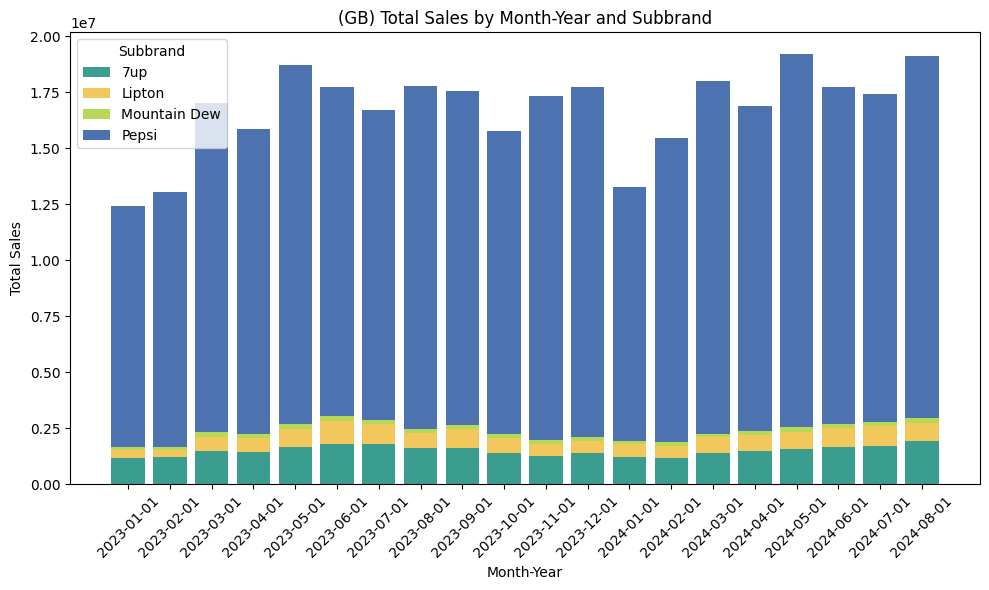

In [118]:

# 3. Agrupamos por YearMonth y SUBBRAND y sumamos AMOUNT
monthly_sales_subbrand = actuals_GB.groupby(['DATE', 'SUBBRAND_GROUPED'])['AMOUNT'].sum().reset_index()

# 4. Pivotamos el DataFrame para que cada SUBBRAND sea una columna
monthly_sales_pivot = monthly_sales_subbrand.pivot(index='DATE', columns='SUBBRAND_GROUPED', values='AMOUNT')

# 5. Colores personalizados
colors = [ '#3b9d8f','#f2c75c', '#b6d957','#4c72b0']  # Lista de colores personalizados

# 6. Crear el gráfico de barras apiladas
plt.figure(figsize=(10, 6))

# Inicializamos la posición inferior de cada barra en 0
bottom = [0] * len(monthly_sales_pivot)

# Iteramos sobre cada subbrand para apilar los valores y aplicar los colores personalizados
for idx, subbrand in enumerate(monthly_sales_pivot.columns):
    plt.bar(monthly_sales_pivot.index.astype(str), monthly_sales_pivot[subbrand],
            bottom=bottom, label=subbrand, color=colors[idx % len(colors)])  # Asignar color con índice
    # Actualizamos la posición inferior sumando el valor actual
    bottom += monthly_sales_pivot[subbrand].fillna(0)  # fillna(0) por si hay valores nulos

# 7. Etiquetas y título
plt.xlabel('Month-Year')
plt.ylabel('Total Sales')
plt.title('(GB) Total Sales by Month-Year and Subbrand')
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje X para mejor visibilidad
plt.legend(title="Subbrand")  # Leyenda para identificar cada SUBBRAND

# 8. Mostrar gráfico
plt.tight_layout()
plt.show()

### TENDENCIA

"Se denomina tendencia de mercado a aquella tendencia en la cual un mercado se mueve en una dirección particular en un intervalo de tiempo; se la llama tendencia principal a lo que corresponde al largo plazo, intermedia para los plazos medianos e inmediata para la corta duración"

https://www.zendesk.com.mx/blog/tendencias-ventas/

### ESTACIONALIDAD

"La estacionalidad de las ventas es el fenómeno por el cual una estación, un periodo del año o un acontecimiento recurrente influyen en las ventas de un producto o servicio. Hay momentos en los que las organizaciones experimentan picos de actividad."

https://www.digdash.com/es/news-articles-es/business-intelligence-es/como-anticipar-la-estacionalidad-de-las-ventas-y-sacar-provecho/#:~:text=La%20estacionalidad%20de%20las%20ventas%20es%20el%20fen%C3%B3meno%20por%20el,organizaciones%20experimentan%20picos%20de%20actividad.

<ipython-input-215-ce7d57dc65bb>:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = actuals_spain_copy.resample('M').sum()  # 'M' es para resampling mensual


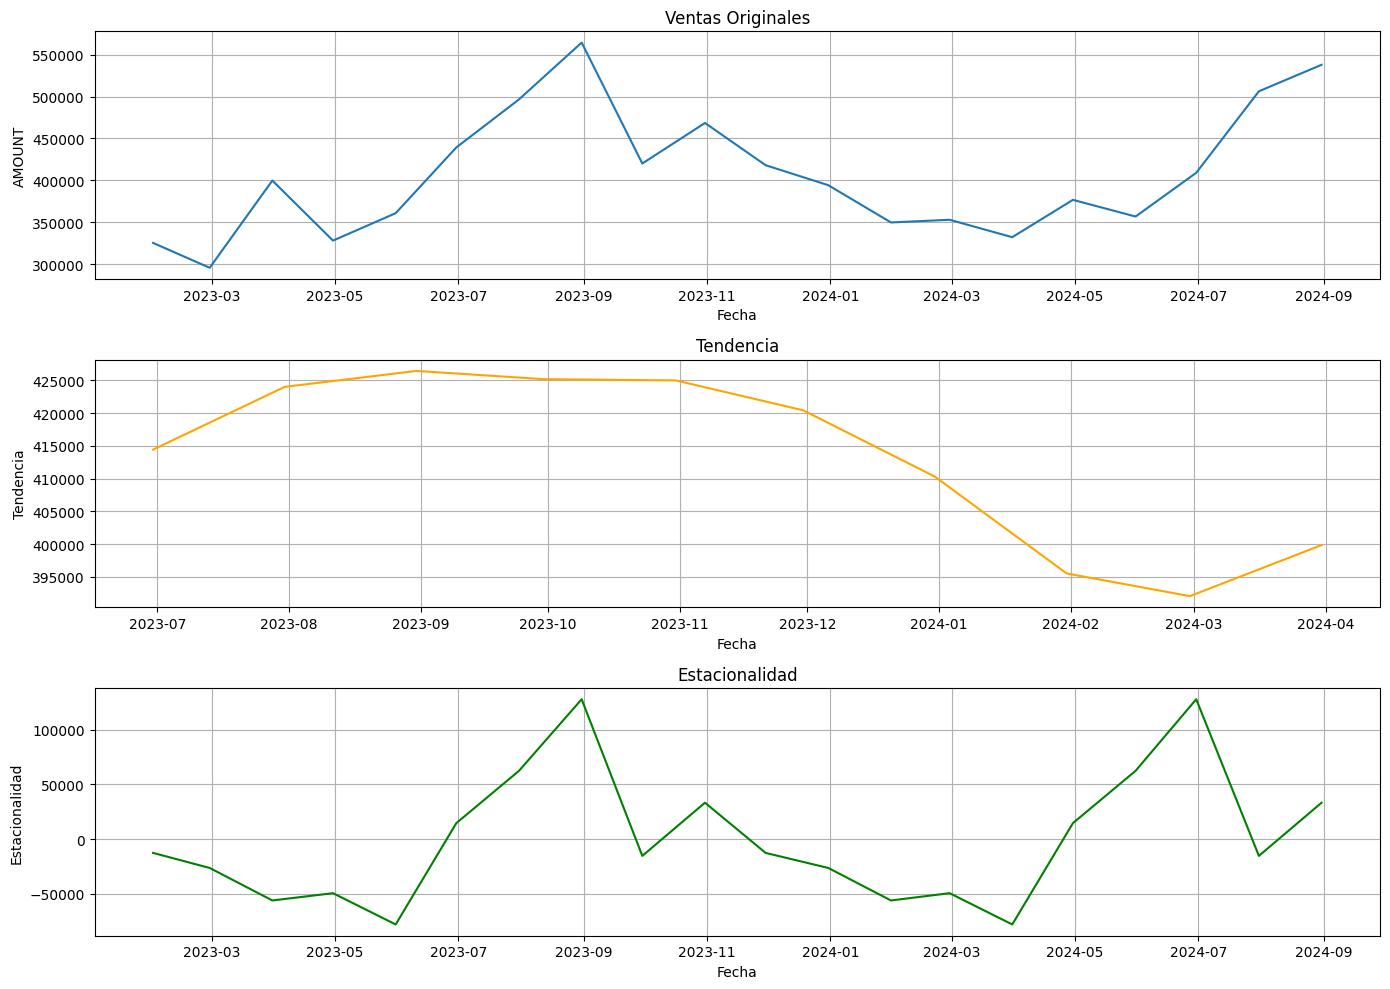

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

actuals_spain = actuals[actuals['COUNTRY'] == 'Spain']
actuals_spain_copy = actuals_spain.copy()

# Aplicar un promedio móvil de 3 meses (ajusta el valor para mayor o menor suavizado)
actuals_spain_copy['Trend'] = actuals_spain_copy['AMOUNT'].rolling(window=3, center=True).mean()

# Establecer la columna 'DATE' como índice
actuals_spain_copy.set_index('DATE', inplace=True)

# Agrupa los datos por mes y año para obtener la suma mensual de ventas
monthly_sales = actuals_spain_copy.resample('M').sum()  # 'M' es para resampling mensual

# Descomponemos la serie temporal con la función seasonal_decompose
# model='additive' es común, pero si tienes mucha variación, prueba con 'multiplicative'
decomposition = seasonal_decompose(monthly_sales['AMOUNT'], model='additive', period=10)

# Extraemos cada componente de la descomposición
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Configuramos el gráfico para visualizar los componentes
plt.figure(figsize=(14, 10))

# Graficamos las ventas originales
plt.subplot(3, 1, 1)
plt.plot(monthly_sales.index, monthly_sales['AMOUNT'], label='Ventas Originales')
plt.title('Ventas Originales')
plt.xlabel('Fecha')
plt.ylabel('AMOUNT')
plt.grid()

# Graficamos la tendencia
plt.subplot(3, 1, 2)
plt.plot(trend, label='Tendencia', color='orange')
plt.title('Tendencia')
plt.xlabel('Fecha')
plt.ylabel('Tendencia')
plt.grid()

# Graficamos la estacionalidad
plt.subplot(3, 1, 3)
plt.plot(seasonal, label='Estacionalidad', color='green')
plt.title('Estacionalidad')
plt.xlabel('Fecha')
plt.ylabel('Estacionalidad')
plt.grid()


# Mostramos el gráfico completo
plt.tight_layout()
plt.show()

# 2. Cual es la tendencia y estacionalidad de:
  * La marca con más ventas

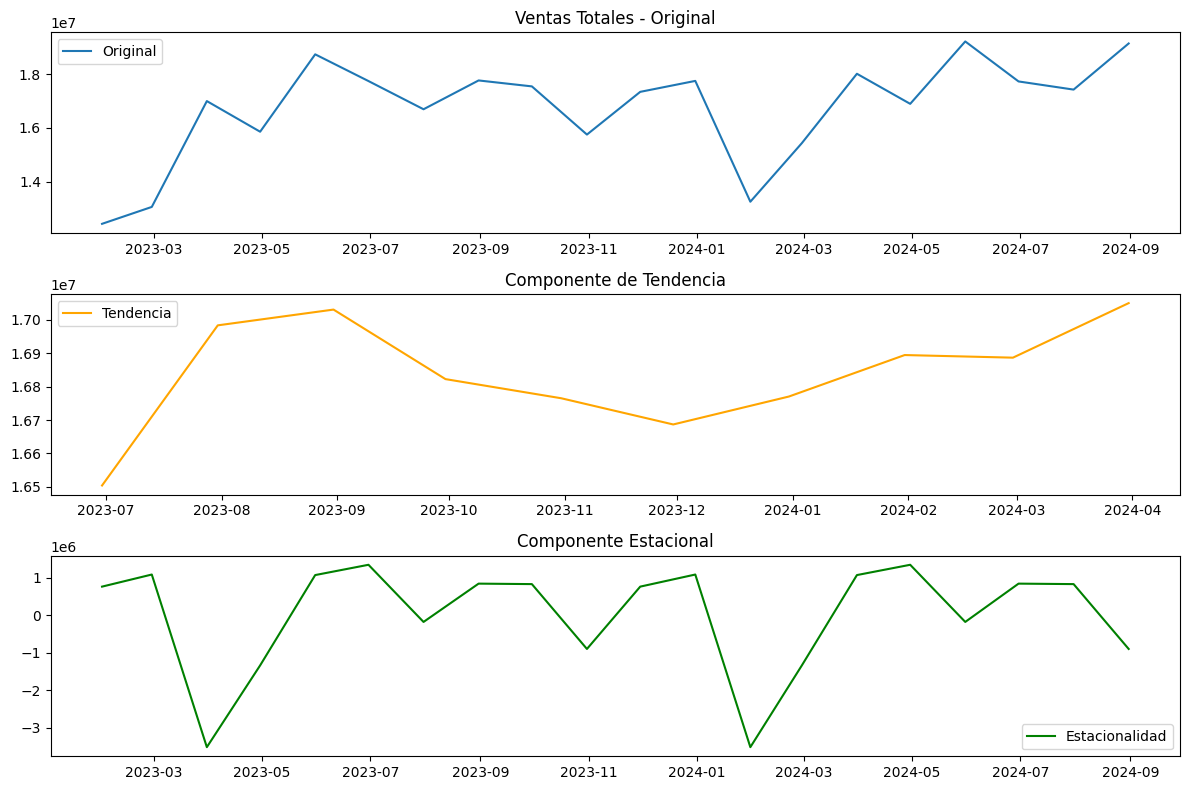

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

actuals_GB_copy = actuals_GB.copy()
# Aplicar un promedio móvil de 3 meses (ajusta el valor para mayor o menor suavizado)
actuals_GB_copy['Trend'] = actuals_GB_copy['AMOUNT'].rolling(window=3, center=True).mean()

# Establecemos 'DATE' como índice para poder usar resample
actuals_GB_copy.set_index('DATE', inplace=True)

# Agrupamos por mes (resample) y sumamos las ventas
monthly_sales = actuals_GB_copy.resample('ME').sum()  # 'M' para mensual

# Descomponemos la serie temporal con la función seasonal_decompose
decomposition = seasonal_decompose(monthly_sales['AMOUNT'], model='additive', period=10)

# Extraemos cada componente de la descomposición
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Configuramos la gráfica
plt.figure(figsize=(12, 8))

# Graficamos los componentes
plt.subplot(311)
plt.plot(monthly_sales['AMOUNT'], label='Original')
plt.title('Ventas Totales - Original')
plt.legend()

plt.subplot(312)
plt.plot(trend, label='Tendencia',color='orange')
plt.title('Componente de Tendencia')
plt.legend()

plt.subplot(313)
plt.plot(seasonal, label='Estacionalidad',color='green')
plt.title('Componente Estacional')
plt.legend()

plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

## 3. Cuales son las predicciones hechas en España y como de buenas son

In [119]:
forecasts_spain = forecasts[forecasts['COUNTRY'] == 'Spain']

In [120]:
forecasts_spain.head(3)

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,DATE,SUBBRAND_GROUPED
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847,2023-12-01,Pepsi
20,Spain,Pepsi Regular (L3),2023,12,AI_forecast,AI_P05F,2023.0,134268.151080,2023-12-01,Pepsi
25,Spain,Lipton (L3),2025,3,AI_forecast,AI_P11F,2023.0,9702.217953,2025-03-01,Lipton


In [122]:
forecast_dates = forecasts_spain['FORECAST'].unique()
print(forecast_dates)

['AI_P09F' 'AI_P05F' 'AI_P11F' 'AI_P04F' 'AI_P02F' 'AI_P12F' 'AI_P06F'
 'AI_P08F' 'AI_PF' 'AI_P07F' 'AI_P10F' 'AI_P03F']


In [123]:
# Definir el orden deseado
custom_order = ['AI_P02F', 'AI_P03F', 'AI_P04F', 'AI_P05F', 'AI_P06F',
                'AI_P07F', 'AI_P08F', 'AI_P09F', 'AI_P10F', 'AI_P11F', 'AI_P12F','AI_PF']

# Ordenamos el array 'forecast_dates' según el orden en 'custom_order'
forecast_dates = sorted(forecast_dates, key=lambda x: custom_order.index(x))
print(forecast_dates)

['AI_P02F', 'AI_P03F', 'AI_P04F', 'AI_P05F', 'AI_P06F', 'AI_P07F', 'AI_P08F', 'AI_P09F', 'AI_P10F', 'AI_P11F', 'AI_P12F', 'AI_PF']


Todas las predicciones se hacen en

In [124]:
forecasts_spain['FORECAST_YEAR'].unique()

array([2023.])

Como solo hay 3 marcas de bebida en el dataset:

In [125]:
forecasts_spain['SUBBRAND_GROUPED'].unique()

array(['Pepsi', 'Lipton', '7up'], dtype=object)

In [126]:
forecasts_spain.head(3)

,COUNTRY,SUBBRAND,YEAR,MONTH,SCENARIO,FORECAST,FORECAST_YEAR,AMOUNT,DATE,SUBBRAND_GROUPED
2,Spain,Pepsi Max (L3),2023,12,AI_forecast,AI_P09F,2023.0,88501.980847,2023-12-01,Pepsi
20,Spain,Pepsi Regular (L3),2023,12,AI_forecast,AI_P05F,2023.0,134268.151080,2023-12-01,Pepsi
25,Spain,Lipton (L3),2025,3,AI_forecast,AI_P11F,2023.0,9702.217953,2025-03-01,Lipton


In [127]:
actuals_spain = actuals[actuals['COUNTRY'] == 'Spain']

In [128]:
forecasts_spain_pepsi = forecasts_spain[forecasts_spain['SUBBRAND_GROUPED'] == 'Pepsi']
forecasts_spain_lipton = forecasts_spain[forecasts_spain['SUBBRAND_GROUPED'] == 'Lipton']
forecasts_spain_7up = forecasts_spain[forecasts_spain['SUBBRAND_GROUPED'] == '7up']

actuals_spain_pepsi = actuals_spain[actuals_spain['SUBBRAND_GROUPED'] == 'Pepsi']
actuals_spain_lipton = actuals_spain[actuals_spain['SUBBRAND_GROUPED'] == 'Lipton']
actuals_spain_7up = actuals_spain[actuals_spain['SUBBRAND_GROUPED'] == '7up']

### PEPSI

Calculo el error total de cada `FORECAST` para `pepsi`

In [129]:
error_pepsi = []
for f in forecast_dates:
  amount_forecast = forecasts_spain_pepsi.loc[forecasts_spain_pepsi['FORECAST'] == f, 'AMOUNT'].sum()
  amount_actual = actuals_spain_pepsi['AMOUNT'].sum()
  # Calculamos el error absoluto y lo agregamos a la lista
  error_pepsi.append(abs(amount_actual - amount_forecast)/ amount_actual * 100)
print(error_pepsi)

[22.669693744599854, 32.40044718060062, 215.20683838390275, 224.11165162087013, 256.48067557646533, 262.3022292449213, 253.51014266293714, 271.1787682157613, 264.975608307976, 287.7968007585859, 281.49465077812744, 20.573149426700272]


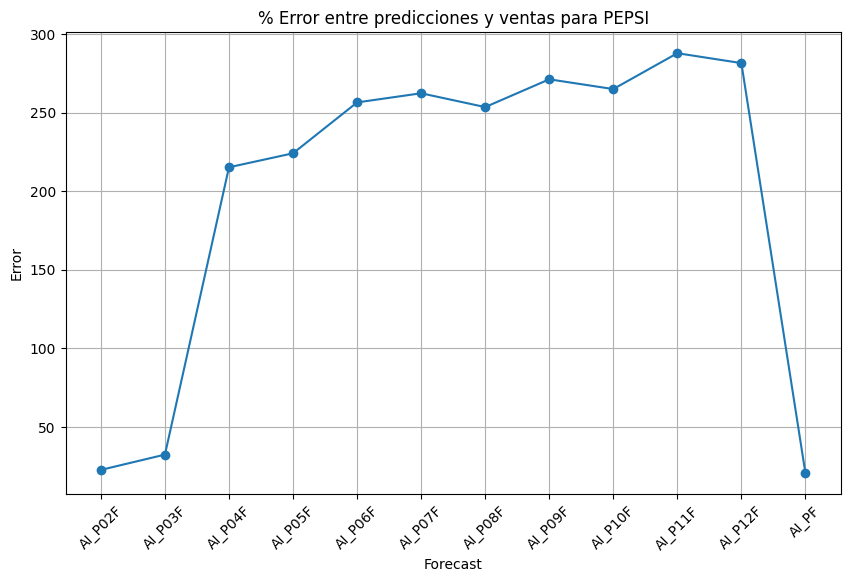

In [131]:
# Graficamos el error
plt.figure(figsize=(10, 6))
plt.plot(forecast_dates, error_pepsi, marker='o', linestyle='-')  # Línea con puntos
plt.xlabel('Forecast')  # Etiqueta del eje X
plt.ylabel('Error')  # Etiqueta del eje Y
plt.title('% Error entre predicciones y ventas para PEPSI')  # Título de la gráfica
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje X para mejorar la legibilidad
plt.grid(True)

# Mostramos el gráfico
plt.show()

## Lipton

Calculo el error total de cada `FORECAST` para `lipton`

In [132]:
error_lipton = []
for f in forecast_dates:
  amount_forecast = forecasts_spain_lipton.loc[forecasts_spain_lipton['FORECAST'] == f, 'AMOUNT'].sum()
  amount_actual = actuals_spain_lipton['AMOUNT'].sum()
  # Calculamos el error absoluto y lo agregamos a la lista
  error_lipton.append(abs(amount_actual - amount_forecast)/ amount_actual * 100)
print(error_lipton)

[34.20886491639948, 17.23729357408443, 20.584736549171033, 24.104888175329844, 24.052227785298058, 26.045372337420307, 22.403170936074755, 13.109051255461427, 16.92457204476055, 13.184809859426863, 10.862482797601537, 37.67160479497458]


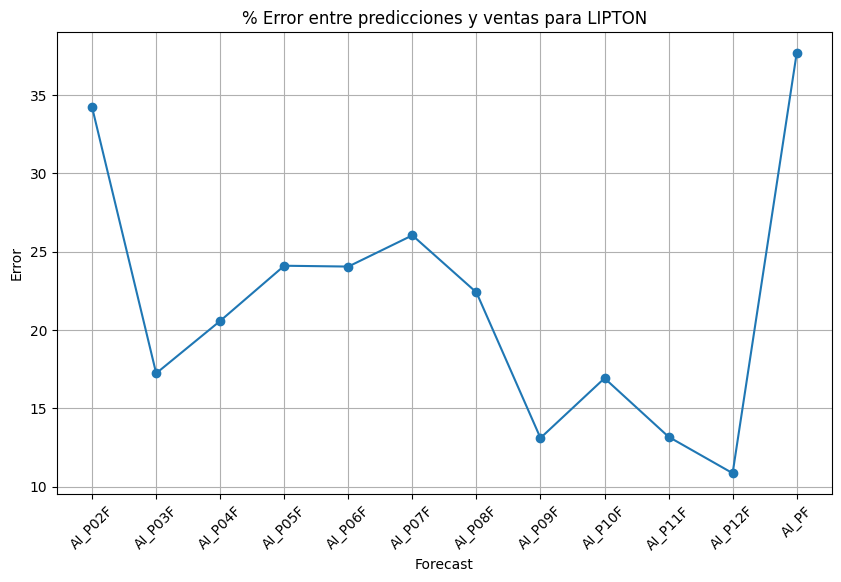

In [134]:
# Graficamos el error
plt.figure(figsize=(10, 6))
plt.plot(forecast_dates, error_lipton, marker='o', linestyle='-')  # Línea con puntos
plt.xlabel('Forecast')  # Etiqueta del eje X
plt.ylabel('Error')  # Etiqueta del eje Y
plt.title('% Error entre predicciones y ventas para LIPTON')  # Título de la gráfica
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje X para mejorar la legibilidad
plt.grid(True)

# Mostramos el gráfico
plt.show()

## 7up

Calculo el error total de cada `FORECAST` para `7up`

In [135]:
error_7up = []
for f in forecast_dates:
  amount_forecast = forecasts_spain_7up.loc[forecasts_spain_7up['FORECAST'] == f, 'AMOUNT'].sum()
  amount_actual = actuals_spain_7up['AMOUNT'].sum()
  # Calculamos el error absoluto y lo agregamos a la lista
  error_7up.append(abs(amount_actual - amount_forecast)/ amount_actual * 100)
print(error_7up)

[23.176080393728764, 22.586862381036816, 25.89156366621326, 26.779674784697814, 33.465288475481145, 34.7108963078613, 40.545806713591084, 30.0632643083813, 28.39199660359151, 15.515396277649563, 27.12592373955019, 23.80214116995282]


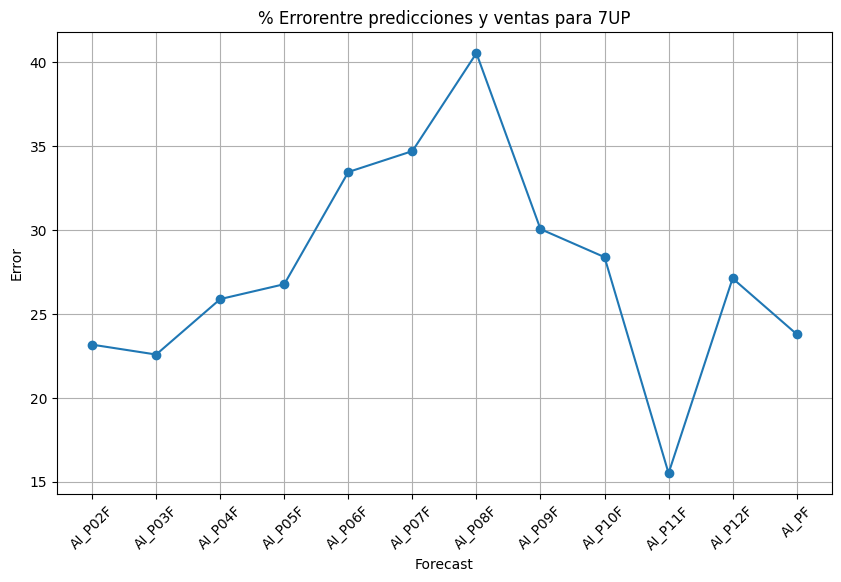

In [137]:
# Graficamos el error
plt.figure(figsize=(10, 6))
plt.plot(forecast_dates, error_7up, marker='o', linestyle='-')  # Línea con puntos
plt.xlabel('Forecast')  # Etiqueta del eje X
plt.ylabel('Error')  # Etiqueta del eje Y
plt.title('% Errorentre predicciones y ventas para 7UP')  # Título de la gráfica
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje X para mejorar la legibilidad
plt.grid(True)

# Mostramos el gráfico
plt.show()

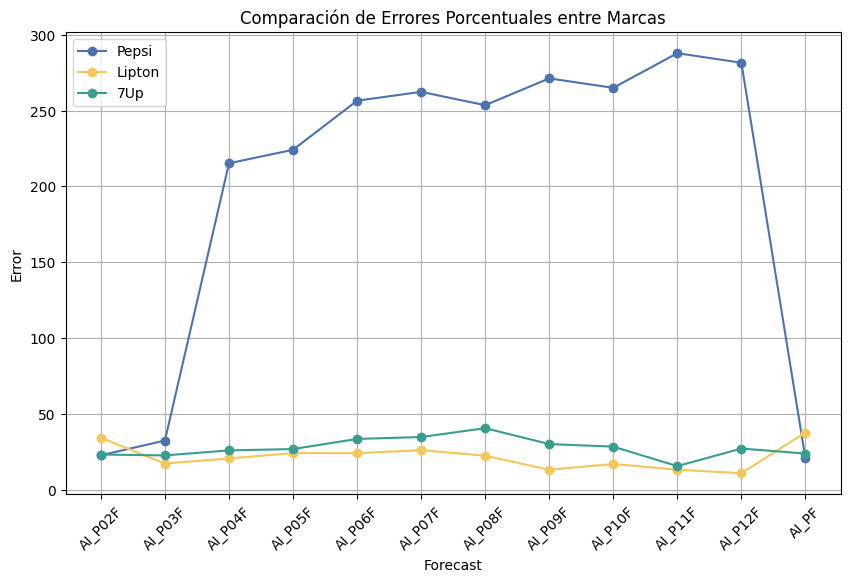

In [143]:
# Graficamos los errores de las tres marcas en el mismo gráfico
plt.figure(figsize=(10, 6))
colors = ['#4c72b0', '#3b9d8f', '#f2c75c', '#b6d957']
# Graficamos error_pepsi
plt.plot(forecast_dates, error_pepsi, marker='o', linestyle='-', color=colors[0], label='Pepsi')

# Graficamos error_lipton
plt.plot(forecast_dates, error_lipton, marker='o', linestyle='-', color=colors[2], label='Lipton')

# Graficamos error_7up
plt.plot(forecast_dates, error_7up, marker='o', linestyle='-', color=colors[1], label='7Up')

# Añadimos las etiquetas y el título
plt.xlabel('Forecast')
plt.ylabel('Error')
plt.title('Comparación de Errores Porcentuales entre Marcas')
plt.xticks(rotation=45)  # Rotamos las etiquetas del eje X para mejorar la legibilidad

# Añadimos la leyenda para identificar cada línea
plt.legend()

# Mostramos la cuadrícula
plt.grid(True)

# Mostramos el gráfico
plt.show()